In [21]:
# import relevant packages
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm

import yfinance as yf
import arch
import pmdarima as pm

# useful settings for ipynb
import warnings
warnings.simplefilter('ignore')

# Download AAPL data and save as dataframe. Choose appropriate window for forecast

In [57]:
# download apple daily stock price from Yahoo finance
df=yf.download("AAPL")# start="2000-01-01", end="2019-01-01")

[*********************100%***********************]  1 of 1 completed


In [58]:
# calculate log returns and remove NaNs
df['Log returns daily'] = 100*np.log(df['Adj Close']/(df['Adj Close'].shift(1)))
df = df.dropna()

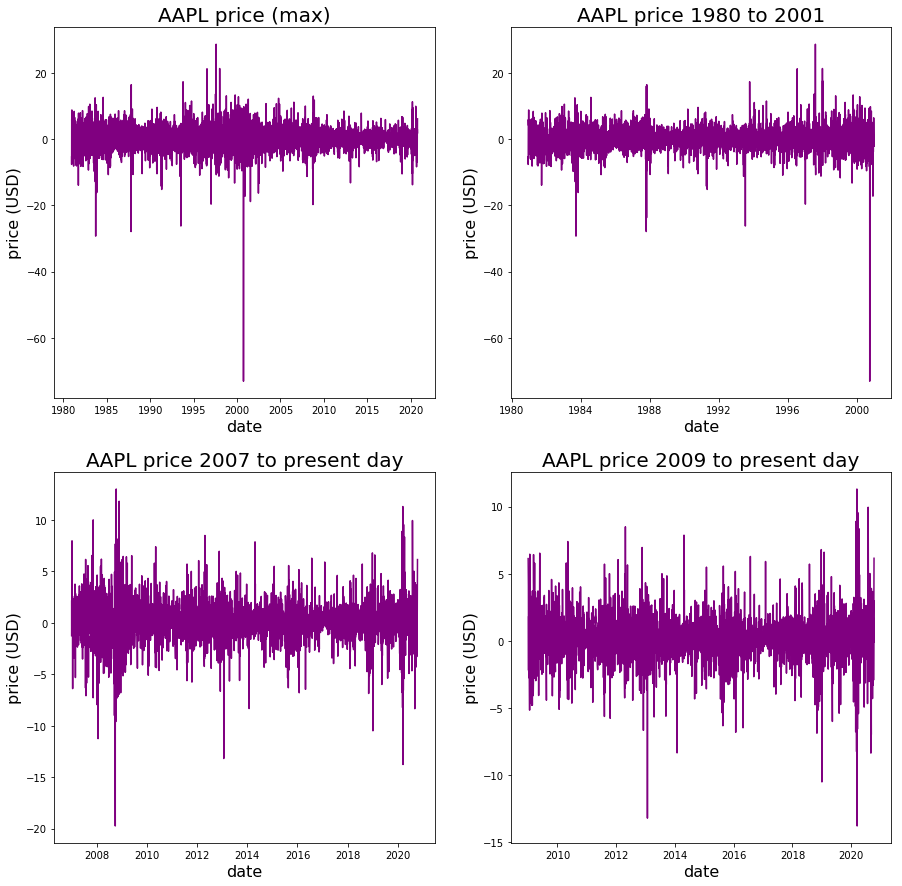

In [59]:
# plot ranges of log returns for AAPLE
# planning to use adj close price for forecast
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15, 15))
fig, ax = plt.subplots(2,2,figsize=(15, 15))
ax[0,0].plot(df['Log returns daily'], color='purple')
ax[0,1].plot(df['Log returns daily'].loc['1980-1-1':'2001-1-1'], color='purple')
ax[1,0].plot(df['Log returns daily'].loc['2007-1-1':], color='purple')
ax[1,1].plot(df['Log returns daily'].loc['2009-1-1':], color='purple')

# set plot titles
ax[0,0].set_title('AAPL price (max)', fontsize=20)
ax[0,1].set_title('AAPL price 1980 to 2001', fontsize=20)
ax[1,0].set_title('AAPL price 2007 to present day', fontsize=20)
ax[1,1].set_title('AAPL price 2009 to present day', fontsize=20)

# set axes labels
for i in range(0,ax.shape[0]):
    for j in range(0,ax.shape[1]):
        ax[i,j].set_xlabel('date',fontsize=16)
        ax[i,j].set_ylabel('price (USD)', fontsize=16)

# chore: axes titles, plot titles (AAPL price from <date range>)

The time series over entire history of stock shows constant mean (0) but contains volatility spikes. This means that a linear model can be used but it is better to use an ARCH type model to account for the heteroscedasticity. Note that the volatility spikes tend to coincide with major financial crises e.g. 1987 stock market crash, dotcom burst (2000), subprime mortgage crisis (2008) etc. We choose the period from 2007 to present because it could be argued that monetary policy was consistent over this period (quantitative easing and increased intervention by central banks). 

In [60]:
# redefine range of time series to be from 2009 - present 
# df = df['Log returns daily'].loc['2009-1-1':'2019-6-1']
df = df['Log returns daily'].loc['2007-1-1':]

# Investigate time series properties

In [61]:
# define time series for various levels of differences d = 0-2
df_d0 = df
df_d1 = df.diff().dropna()
df_d2 = df_d1.diff().dropna()
df_d3 = df_d2.diff().dropna()

Text(0.5, 0.98, 'ACF/PACF for TS with d = 0')

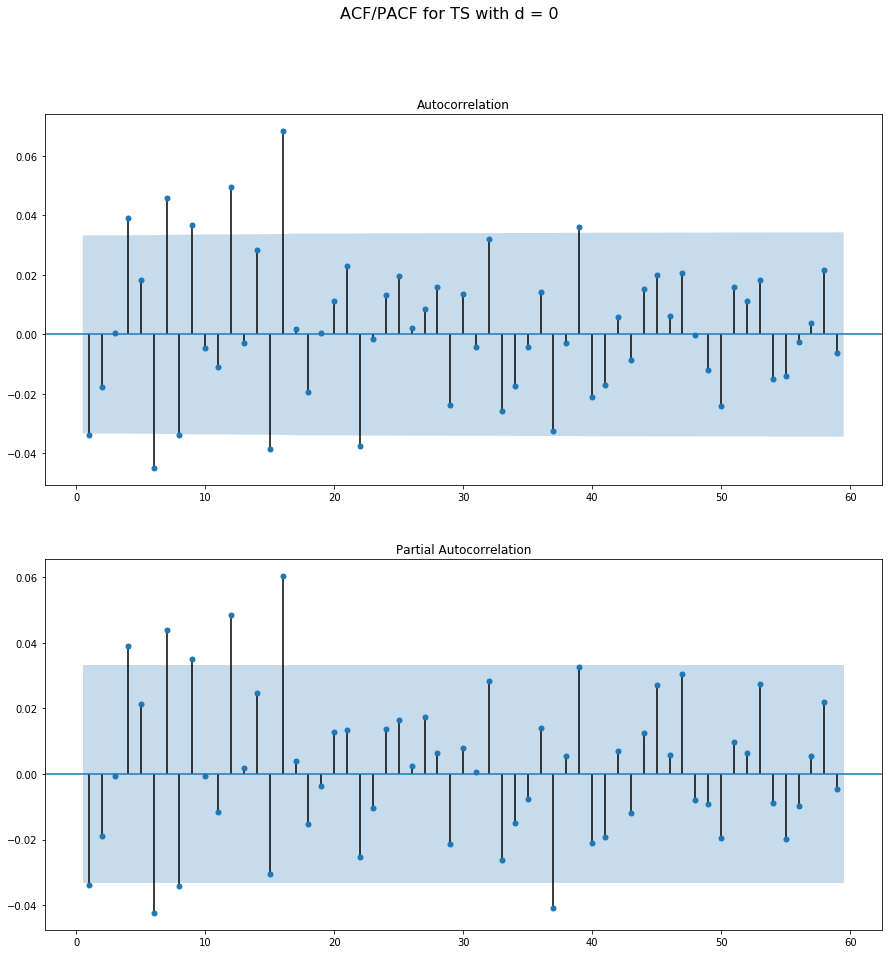

In [62]:
# plot ACF/PACF for original time series
fig, (ax1, ax2) = plt.subplots(2,figsize=(15, 15))
sm.graphics.tsa.plot_acf(df, ax1, lags=np.arange(1,60));
sm.graphics.tsa.plot_pacf(df, ax2, lags=np.arange(1,60));
fig.suptitle('ACF/PACF for TS with d = 0', fontsize=16)

Text(0.5, 0.98, 'ACF/PACF for TS with d = 1')

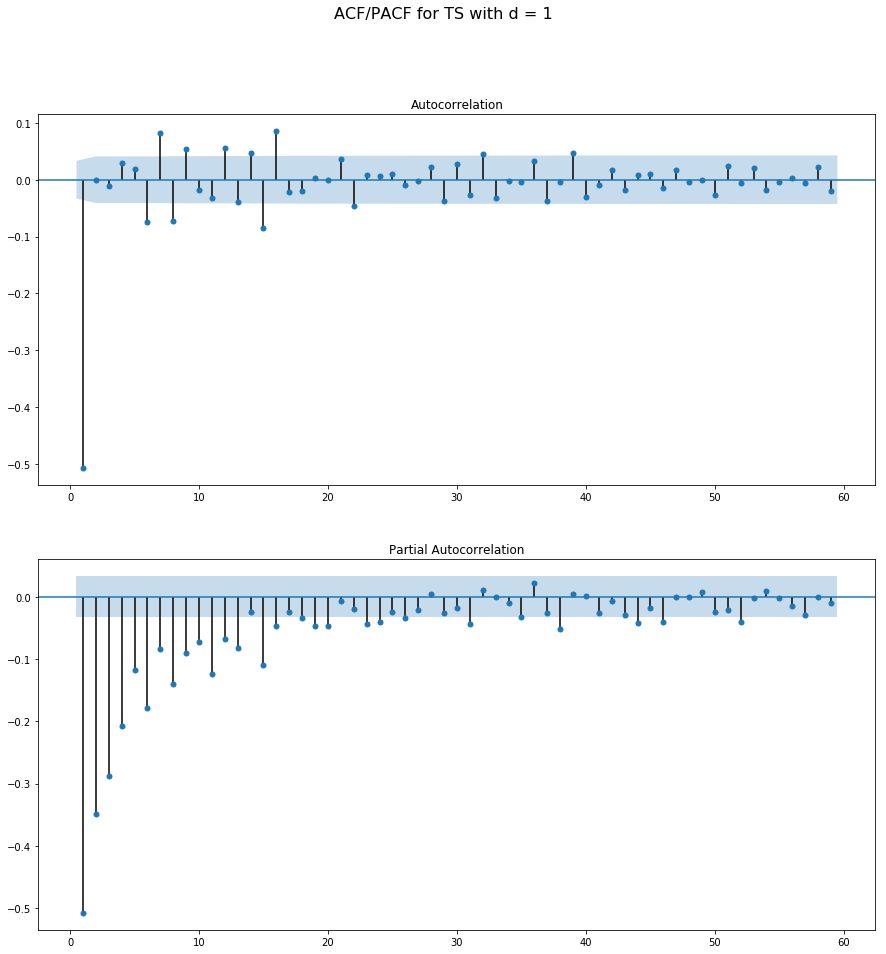

In [63]:
# plot ACF/PACF for first difference of time series
fig, (ax1, ax2) = plt.subplots(2,figsize=(15, 15))
sm.graphics.tsa.plot_acf(df_d1, ax1, lags=np.arange(1,60));
sm.graphics.tsa.plot_pacf(df_d1, ax2, lags=np.arange(1,60));
fig.suptitle('ACF/PACF for TS with d = 1', fontsize=16)

almost looks like an ARIMA(0,1,1) process

Text(0.5, 0.98, 'ACF/PACF for TS with d = 2')

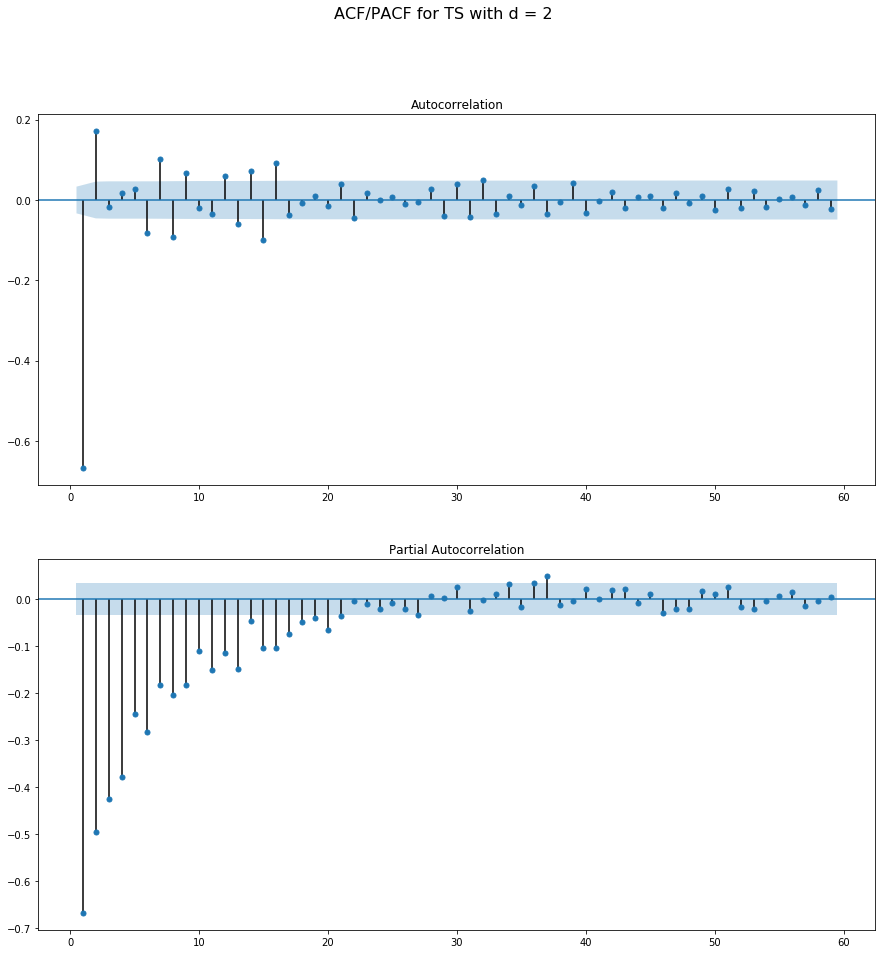

In [64]:
# plot ACF/PACF for second difference of time series
fig, (ax1, ax2) = plt.subplots(2,figsize=(15, 15))
sm.graphics.tsa.plot_acf(df_d2, ax1, lags=np.arange(1,60));
sm.graphics.tsa.plot_pacf(df_d2, ax2, lags=np.arange(1,60));
fig.suptitle('ACF/PACF for TS with d = 2', fontsize=16)

In [65]:
# perform stationarity tests (ADF) additionally print out normality statistics
dftest = sm.tsa.stattools.adfuller(df.values)
dftest_output = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dftest_output['Critical Value (%s)'%key] = value
print(dftest_output)

Test Statistic                -1.316208e+01
p-value                        1.301159e-24
#Lags Used                     1.500000e+01
Number of Observations Used    3.453000e+03
Critical Value (10%)          -2.567216e+00
Critical Value (1%)           -3.432245e+00
Critical Value (5%)           -2.862377e+00
dtype: float64


In [66]:
# perform stationarity tests (KPSS)
dftest1 = sm.tsa.stattools.kpss(df)
dftest1_out = pd.Series(dftest1[0:3], index=['Test Statistic','p-value','#Lags used'])
for key, value in dftest1[3].items():
    dftest1_out['Critical Value (%s)'%key] = value
print(dftest1_out)

Test Statistic            0.059665
p-value                   0.100000
#Lags used               30.000000
Critical Value (10%)      0.347000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


Comments: original TS is stationary according to both ADF and KPSS. First order difference TS looks like it might be an ARMA(0,1) process

# Determine optimal parameters p, q for ARMA(p,q)

Although unnecessary, determine optimal parameters for ARMA(p,q) to model the conditional mean using AIC criterion.

In [75]:
model = pm.auto_arima(df,
                      start_p=1, start_q=1,                             
                      max_p=5, max_q=5, max_d=2,                             
                      seasonal=False, max_order = 10,                            
                      d=0, trace=True,           
                      error_action='ignore',  # don't want to know if an order does not work                         
                      suppress_warnings=True,  # don't want convergence warnings   
                      stepwise=True)  # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=14855.376, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14855.142, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=14853.832, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=14853.728, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=14855.051, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=14851.486, Time=0.54 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=14856.811, Time=0.50 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=14859.041, Time=0.21 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=14856.889, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=14856.957, Time=0.32 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=14861.087, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=14847.843, Time=1.20 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=14845.851, Time=0.36 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=14844.850, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0

It appears that an MA(1) process is preferred for modelling the conditional mean of the time series.

In [76]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3469
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -7419.425
Date:                Tue, 13 Oct 2020   AIC                          14844.850
Time:                        13:27:16   BIC                          14863.305
Sample:                             0   HQIC                         14851.440
                               - 3469                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1112      0.034      3.247      0.001       0.044       0.178
ma.L1         -0.0352      0.010     -3.467      0.001      -0.055      -0.015
sigma2         4.2194      0.048     87.944      0.0

Fit the model to the time series.

In [77]:
model = sm.tsa.arima.ARIMA(df, order=(0,0,1))
model = model.fit()

Plot diagnostic plots for the model.

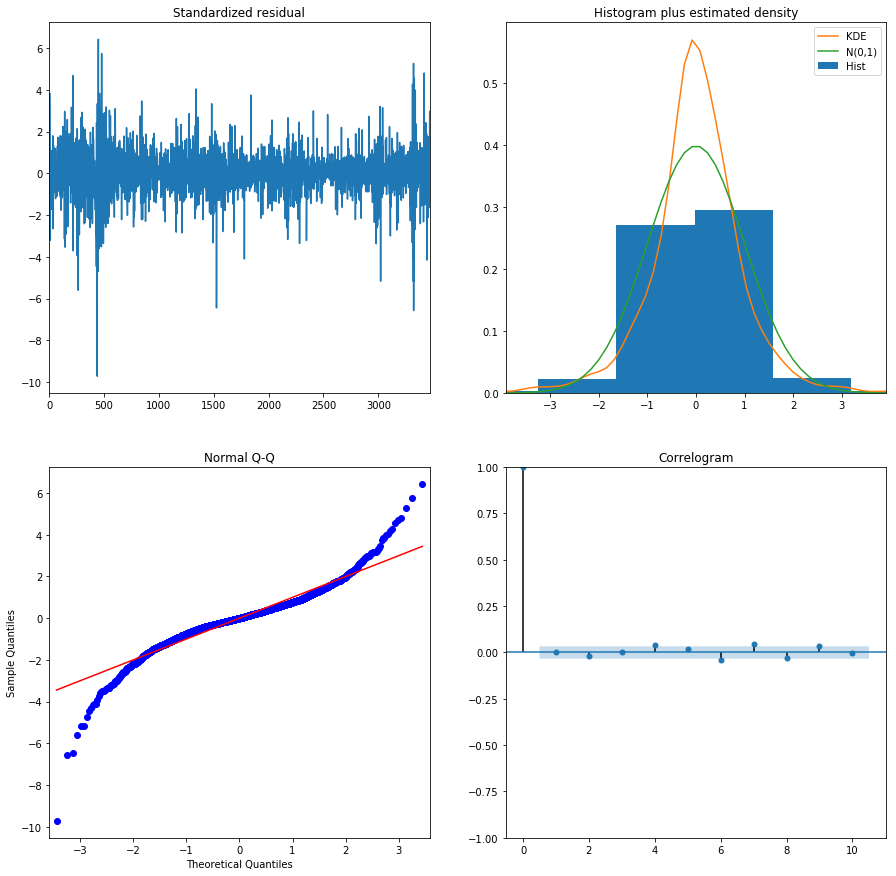

In [78]:
model.plot_diagnostics(figsize=(15,15));

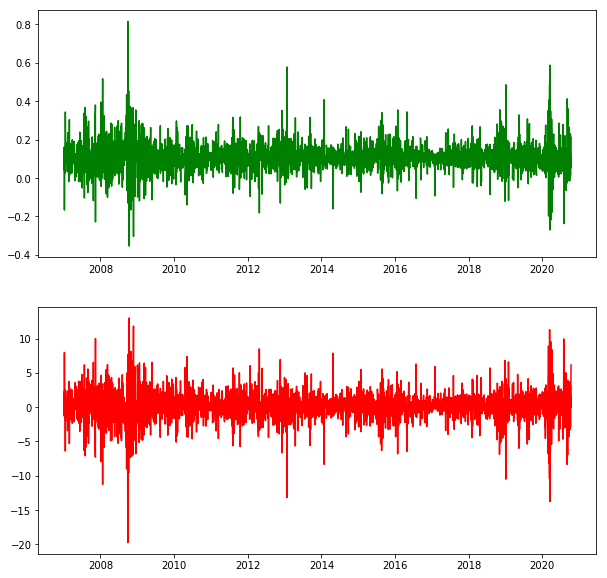

In [80]:
fig, ax = plt.subplots(2, figsize=(10,10))
ax[0].plot(model.predict(1),color = 'green')
ax[1].plot(df, color = 'red')

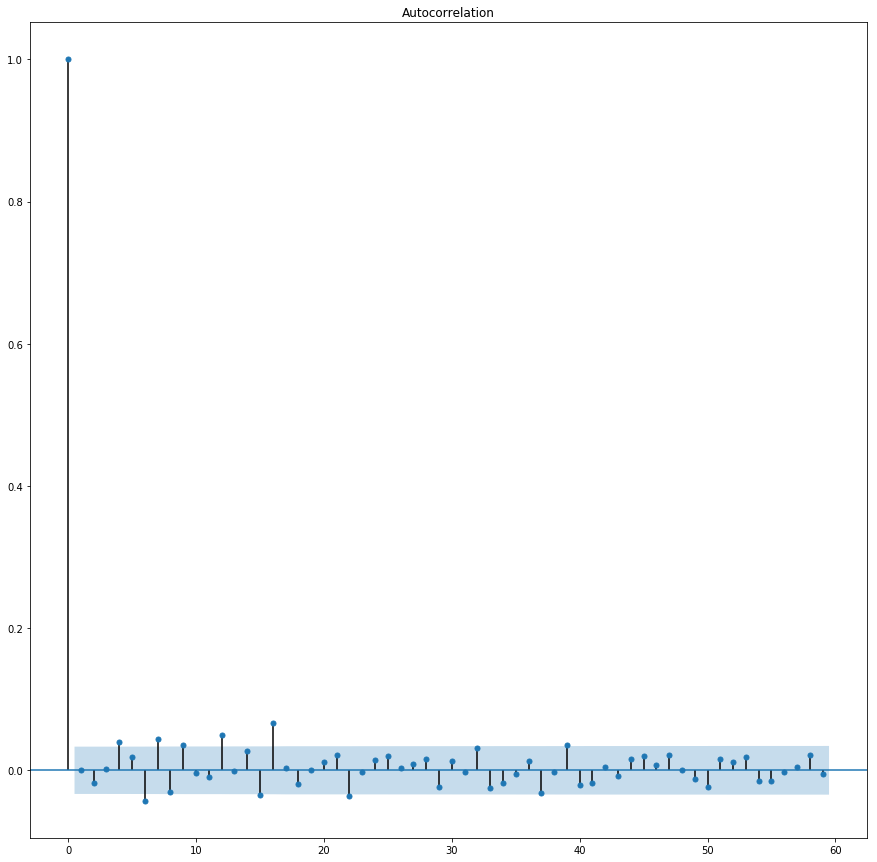

In [81]:
fig, ax1 = plt.subplots(1,figsize=(15, 15))
sm.graphics.tsa.plot_acf(model.resid, ax1, lags=np.arange(0,60));

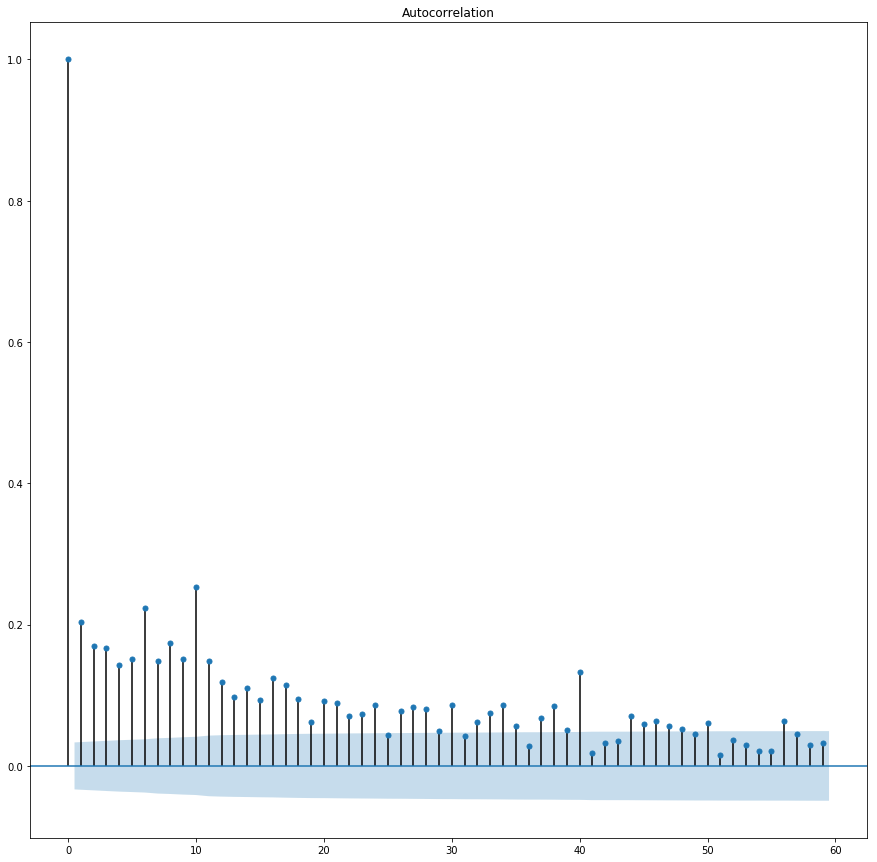

In [82]:
fig, ax1 = plt.subplots(1,figsize=(15, 15))
sm.graphics.tsa.plot_acf(model.resid**2, ax1, lags=np.arange(0,60));

i.e. heteroscedastic behaviour

determine p and q parameters in GARCH for conditional variance

In [83]:
# p and q are stored in the indices of GARCH_array while the values in the GARCH[i,j] correspond to the AIC
min_p = 1
max_p = 5
min_q = 0
max_q = 5
GARCH_array = np.zeros((max_p,max_q))
for i in range(min_p,max_p): # this is the range of p values to be tested
    for j in range(min_q,max_q): # range of q values to be tested
        garch_model = arch.arch_model(model.resid, p=i, q=j,vol='GARCH'); # GARCH model can be specified here
        GARCH_array[i,j] = garch_model.fit(update_freq=10).aic;
        
GARCH_AIC_summary = pd.DataFrame(GARCH_array)

Iteration:     10,   Func. Count:     60,   Neg. LLF: 7246.783536022189
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7246.783536022039
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
Iteration:     10,   Func. Count:     73,   Neg. LLF: 6960.073135767441
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6960.0731357648
            Iterations: 10
            Function evaluations: 73
            Gradient evaluations: 10
Iteration:     10,   Func. Count:     84,   Neg. LLF: 6960.0532633961375
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6960.030107699626
            Iterations: 13
            Function evaluations: 106
            Gradient evaluations: 13
Iteration:     10,   Func. Count:     92,   Neg. LLF: 6959.837990500424
Optimization terminated successfully.    (Exit mode 0)
            Current functio

In [84]:
GARCH_AIC_summary = GARCH_AIC_summary.iloc[1:] # delete first row corresponding to p = 0 which is not allowed

In [85]:
GARCH_AIC_summary

,0,1,2,3,4
1,14499.567072,13928.146272,13930.060215,13931.664185,13932.934957
2,14318.577165,13930.146272,13932.060216,13933.170843,13933.054657
3,14212.030518,13932.146271,13934.060215,13933.472350,13934.508369
4,14165.166081,13934.146271,13936.060216,13935.472350,13936.508106


In [86]:
garch11 = arch.arch_model(model.resid, p=1, q=1,vol='GARCH')
garch11 = garch11.fit()
print(garch11.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6970.135930172356
Iteration:      2,   Func. Count:     17,   Neg. LLF: 6964.043364472531
Iteration:      3,   Func. Count:     26,   Neg. LLF: 6962.5571623633905
Iteration:      4,   Func. Count:     34,   Neg. LLF: 6961.720551644852
Iteration:      5,   Func. Count:     42,   Neg. LLF: 6960.578798293434
Iteration:      6,   Func. Count:     49,   Neg. LLF: 6960.117858114048
Iteration:      7,   Func. Count:     55,   Neg. LLF: 6960.074922273291
Iteration:      8,   Func. Count:     61,   Neg. LLF: 6960.073206528328
Iteration:      9,   Func. Count:     67,   Neg. LLF: 6960.073139818931
Iteration:     10,   Func. Count:     73,   Neg. LLF: 6960.073135767441
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6960.0731357648
            Iterations: 10
            Function evaluations: 73
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results               

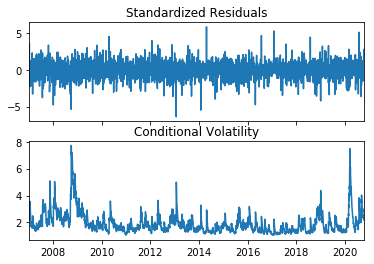

In [87]:
garch11.plot();

In [88]:
garch11.resid

Date
2007-01-03   -1.427090
2007-01-04    1.954349
2007-01-05   -0.836651
2007-01-08    0.272347
2007-01-09    7.798804
2007-01-10    4.758345
2007-01-11   -1.268111
2007-01-12   -1.474808
2007-01-16    2.344547
2007-01-17   -2.347355
2007-01-18   -6.666209
2007-01-19   -1.067448
2007-01-22   -2.179495
2007-01-23   -1.531335
2007-01-24    0.915383
2007-01-25   -0.678956
2007-01-26   -1.228502
2007-01-29    0.419723
2007-01-30   -0.630840
2007-01-31   -0.002821
2007-02-01   -1.352395
2007-02-02   -0.226572
2007-02-05   -1.159114
2007-02-06    0.018289
2007-02-07    2.158735
2007-02-08   -0.079945
2007-02-09   -3.628594
2007-02-12    1.596481
2007-02-13   -0.346868
2007-02-14    0.502925
                ...   
2020-08-31    3.130095
2020-09-01    3.825386
2020-09-02   -2.149718
2020-09-03   -8.611242
2020-09-04   -0.427783
2020-09-08   -7.172472
2020-09-09    3.467870
2020-09-10   -3.387751
2020-09-11   -1.631634
2020-09-14    2.707655
2020-09-15    0.060451
2020-09-16   -3.184447
2020-0

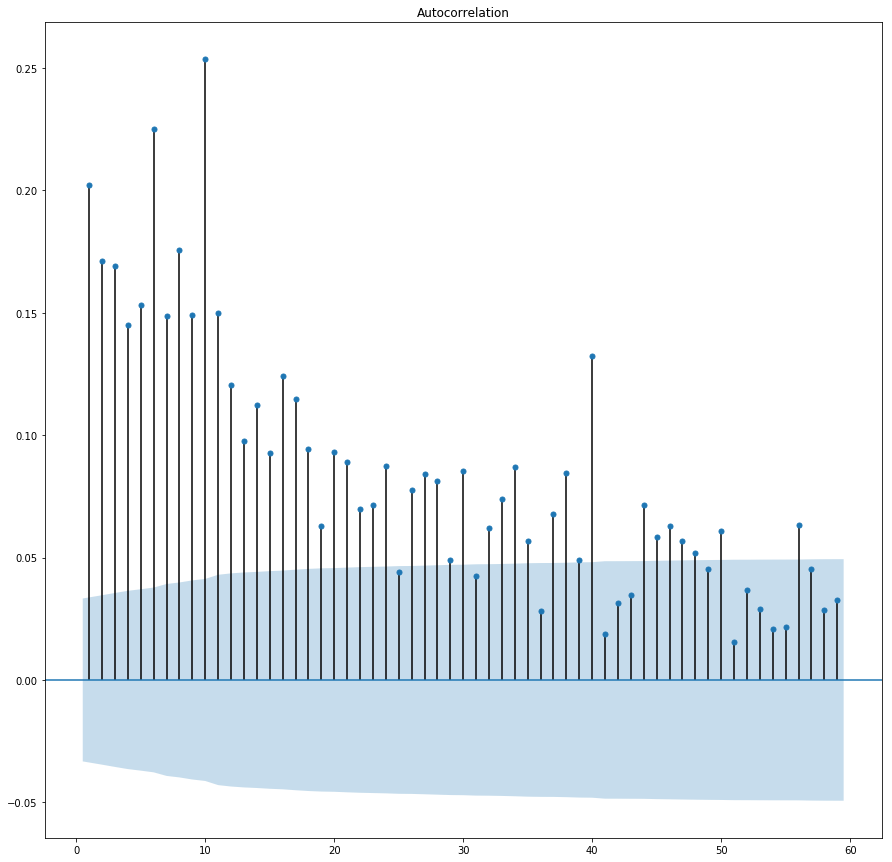

In [89]:
fig, ax1 = plt.subplots(1,figsize=(15, 15))
sm.graphics.tsa.plot_acf(garch11.resid**2, ax1, lags=np.arange(1,60));

In [ ]:
model.forecast(horizon=1)